In [1]:
%matplotlib inline
import numpy as np
import math
from scipy.constants import speed_of_light
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import animation as ani
from IPython.display import HTML
from tqdm import tqdm
import pickle
from AsymptoticRingModeSolver import Clothoid3, SystemParameters, Resonance

Lr = (2*math.pi) * (120e-6)        # Length of the resonator (m)
omega_c = 0                        # Coupling coefficient between the ring and waveguide (Here set to zero since we are only interested in an isolated ring)
N_mesh = 900                       # Number of discretized mesh points along the length of the resonator

# Single Pass Resonator Fields - Example

In this example, rather than compute the full asymptotic field amplitudes for the coupled resonator and waveguide, we will instead consider the fields along a single pass of the ring (here a three bend clothoid triangle).

First, we start by loading in a previously generated binary file containing the fitting parameters for the ring and waveguide modes (See <i>modePropertyGeneration.ipynb</i> for details on the mode parameter fitting). Here, we will use a pregenerated fit over a range of TE00 and TE01 modes corresponding to wavelength between 1.45 \$ \mu m\$ to 1.65 \$ \mu m\$, bend radii from 0 \$\mu m^{-1}\$ to 0.05 \$\mu m^{-1}\$, and waveguide / resonator cross-section width from 2.1 \$ \mu m\$ to 2.9 \$ \mu m\$ (cross-section hight fixed at 0.38 \$ \mu m\$).

In [2]:
fitFile = open("sampleData/sampleFittedBinary", 'rb')
modePars_raw = pickle.load(fitFile)
fitFile.close()

Next, we generate the class describing the clothoid triangle geometry.

In [3]:
clothoidParDict = {
    "resonatorLength" : Lr,               # Length of the resonantor (m)
    "bendOrder" : 1.0,                    # Order of the clothoid bends
    "curveFraction" : 1.0,                # Fraction of the resonator length comprised of the clothoid bends (remaining length correspond to straight sections between the bends)
    "couplingLengthFraction" : 0.5        # Fraction of one triangle side corresponding to the coupling region with the waveguide
}
resonator = Clothoid3(clothoidParDict)

Construct the class that will house the properties of the system including modal and material properties.

In [4]:
systemParsDict = {
    "resonator" : resonator,                      # Resonator structure
    "lambda" : 1550e-9,                           # Reference system wavelength. Resonance with index n=0 corresponds to the resonance nearest this value, with n=+/-1 those directly adjacent. 
    "waveguideWidth" : 2.5,                       # Width of the waveguide / resonantor cross-section (um)
    "meshSize" : N_mesh,                          # Number of discretized position bins along the length of the resonator structure
    "omega_c" : 0,                                # Waveguide/resonator coupling coefficient (TAKEN TO BE CONSTANT, WILL HAVE FREQUENCY AND MODE DEPENDENCE IN FUTURE UPDATE)
    "scatteringLoss_dB" : [0.3, 0.4],             # Phenomenological scattering loss coefficients [TE00, TE01] (dB/cm)
    "modePars_raw" : modePars_raw                 # Dictionary of raw mode property fitting parameters
}
systemPars = SystemParameters(systemParsDict)

Plot some properties of the resonator structure and waveguide modes.

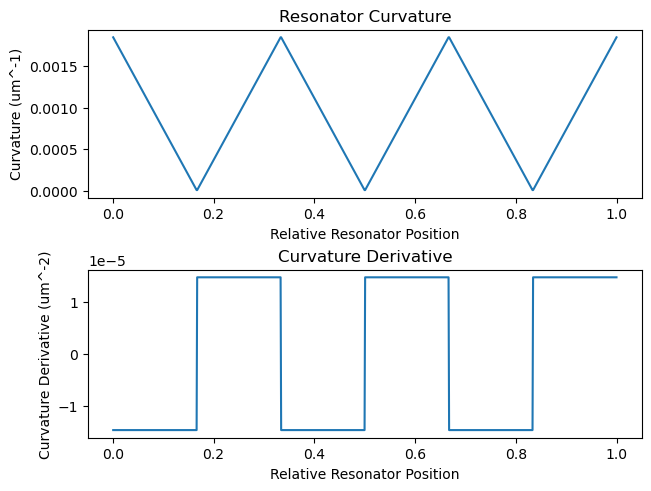

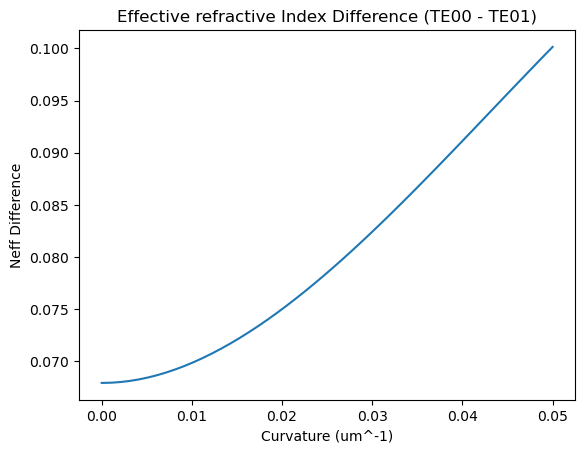

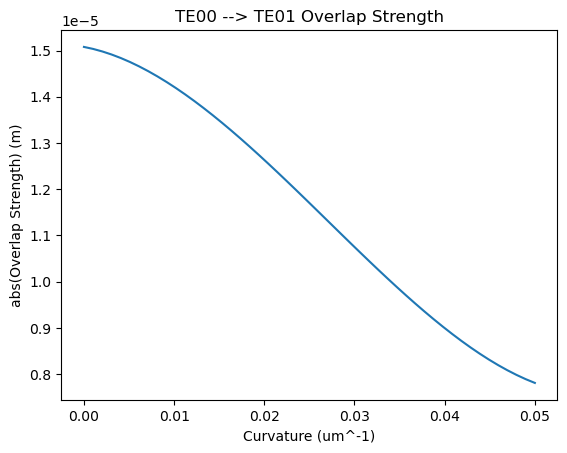

In [5]:
systemPars.PlotResonatorCurvature()
systemPars.PlotNeffDiff()
systemPars.PlotOverlapStrength()

## Waveguide Width Sweep

For this section, we will consider only a single frequency (wavelength) point, and sweep through different values of the waveguide (resonator) cross-sectional width. For this reason, we will set the number of frequency points to 1 and the frequency range to 0 in the resonance definition below.

In [6]:
resonanceDict = {
    "systemPars" : systemPars,                # System parameter class
    "lambda0" : 1550e-9,                      # Central wavelength of the resonance (m)
    "omegaRange" : 0,                         # Frequency range of the resonance (2pi Hz)
    "Nf" : 1,                                 # Number of frequncy points 
    "generateAsyFields" : False               # Skips the generation of the full asymptotic fields (to save some time)
}
res = Resonance(resonanceDict)

Generating single pass fields...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.12it/s]


With the resonance intialized at the desired frequency, we can now perform a sweep over the cross-sectional widths. We will choose to do this over a range from 2.2 \$ \mu m\$ to 2.8 \$ \mu m \$, and consider the TE01 mode field in the resonator coming from a TE00 input.

(Note from the plot of the resonator curvature above, the 'zero point' of the clothoid triangle corresponds to a peak in one of the bends. For the following discussion it will be more convienient to define the single pass ring quantities in terms of an inital point with zero curvature. for this reason, when solving for the single pass resonator field we will introduce a shift in the mesh index corresponding to 1/6 the length of the resonator (In this case 900/6 = 150).)

Performing cross-sectional width sweep...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:17<00:00,  7.75it/s]


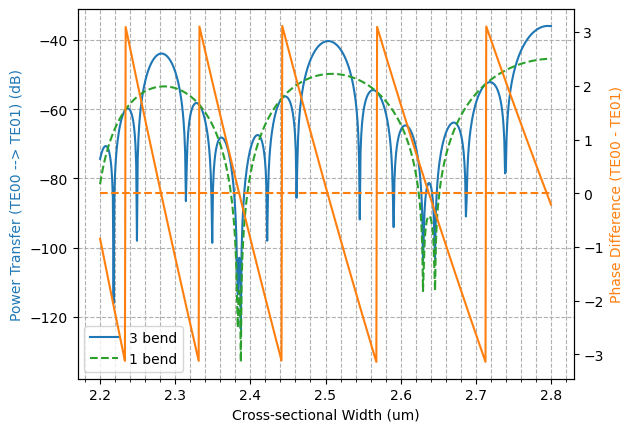

In [7]:
frequencyIndex = 0                                          # Fixed at 0 since we are only generating a single frequency point
inMode = 0; outMode = 1                                     # inMode = TE00, outMode = TE01
meshShift = int(N_mesh/6)                                   # Shift the zero of the resonator to a flat point (see above)

singlePassPhase_1bend = []                                  # Diagonal phase difference after 1 bend
singlePassAmp_1bend = []                                    # Field transfer after 1 bend
singlePassAmp_3bend = []                                    # Field transfer after 3 bends

widthVec = np.linspace(2.2, 2.8, 600)
for width in tqdm(widthVec, desc="Performing cross-sectional width sweep..."):
    res.ResetWaveguideWidth(width)
    resonatorFieldMat = res.GetSinglePassField(frequencyIndex, posIndexShift=meshShift)

    singlePassPhase_1bend.append(np.angle(resonatorFieldMat[0, 0, int(N_mesh/3) - 1] * np.conj(resonatorFieldMat[1, 1, int(N_mesh/3) - 1])))
    singlePassAmp_1bend.append(resonatorFieldMat[inMode, outMode, int(N_mesh/3) - 1])         
    singlePassAmp_3bend.append(resonatorFieldMat[inMode, outMode, N_mesh - 1])                   

fig, ax = plt.subplots(1,1)
ax.plot(widthVec, 20 * np.log10(np.absolute(np.array(singlePassAmp_3bend))), label="3 bend", color='tab:blue')
ax.plot(widthVec, 20 * np.log10(np.absolute(np.array(singlePassAmp_1bend))), "--", label="1 bend", color='tab:green')
ax.set_ylabel("Power Transfer (TE00 --> TE01) (dB)", color='tab:blue')
ax.set_xlabel("Cross-sectional Width (um)")
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax.grid(which='both', linestyle="--")
ax.legend()

ax_p = ax.twinx()
ax_p.plot(widthVec, singlePassPhase_1bend, color='tab:orange')
ax_p.plot(widthVec, np.zeros(len(widthVec)), "--", color='tab:orange')
ax_p.set_ylabel("Phase Difference (TE00 - TE01)", color='tab:orange')

plt.show()

## Wavelength Sweep

Now we look to fix the cross-sectional width, but vary the wavelength of the input field. This will be similar to the previous section, but here the fields can all be solved in one step rather than repeatedly modifying the cross-section width. We start by defining the resonance properties.

In [8]:
resonanceDict = {
    "systemPars" : systemPars,          # System parameter class
    "lambda0" : 1550e-9,                # Central wavelength of the resonance (m)
    "omegaRange" : 3e13,                # Frequency range of the resonance (2pi Hz)
    "Nf" : 200,                         # Number of frequncy points 
    "generateAsyFields" : False         # Skips the generation of the full asymptotic fields (to save some time)
}
res = Resonance(resonanceDict)

Generating single pass fields...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.61it/s]


With this resonance object, we now make an animation of a wavelength sweep displaying:
<ul>
    <li>The power transfer from a TE00 input into the TE01 mode as a function of wavelength.</li>
    <li>The virtual intrinsic Q factor and power fraction of the resonator eigen modes as a function of wavelength. </li>
    <li>The power transfer from the TE00 to TE01 mode within the resonator as a function of the relative resonator position.</li>
</ul>
The animation is then saved with the provided file name and displayed below.

In [9]:
inMode = 0; outMode = 1                                     # inMode = TE00, outMode = TE01
meshShift = int(N_mesh/6)                                   # Shift the zero of the resonator to a flat point
wavelengths = res.lambda_vec 
relativePositions = res.systemPars.meshPositions[1:] / Lr

singlePassAmp_1bend = []
singlePassAmp_3bend = []
virtualQ_3bend = []
eigenModeFrac_3bend = []
resonatorField = []
for frequencyIndex in range(len(res.omega_vec)):
    omega = res.omega_vec[frequencyIndex]
    vg = speed_of_light / res.systemPars.Ng(0, wavelengths[frequencyIndex], 0)
    resonatorFieldMat = res.GetSinglePassField(frequencyIndex, posIndexShift=meshShift)

    singlePassAmp_1bend.append(resonatorFieldMat[inMode, outMode, int(N_mesh/3) - 1])         
    singlePassAmp_3bend.append(resonatorFieldMat[inMode, outMode, N_mesh - 1]) 
    resonatorField.append(resonatorFieldMat[inMode, outMode, :])

    eigs, eigenVecs = np.linalg.eig(resonatorFieldMat[:, :, N_mesh - 1])
    eigenModeFrac_3bend.append([abs(eigenVecs [0, i_vec])**2 / sum(abs(eigenVecs[:, i_vec])**2) for i_vec in range(2)])
    virtualQ_3bend.append([(omega * Lr / (2 * (1 - abs(eigs[i_mode])) * vg)) for i_mode in range(2)])

fig, ax = plt.subplots(3, 1, constrained_layout=True)
fig.set_size_inches(10, 10)
fig.suptitle(f"Cross-sectional Width = {res.systemPars.waveguideWidth} um")

virtualQ_3bend = np.array(virtualQ_3bend)
eigenModeFrac_3bend = np.array(eigenModeFrac_3bend)
resonatorField = np.array(resonatorField)
maxTransfer = np.max([20 * np.log10(np.absolute(singlePassAmp_3bend)), 20 * np.log10(np.absolute(singlePassAmp_1bend))])
minTransfer = np.min([20 * np.log10(np.absolute(singlePassAmp_3bend)), 20 * np.log10(np.absolute(singlePassAmp_1bend))])

ax[0].plot(wavelengths * 1e9, 20 * np.log10(np.absolute(singlePassAmp_3bend)), color='tab:blue', label="3 bend")
ax[0].plot(wavelengths * 1e9, 20 * np.log10(np.absolute(singlePassAmp_1bend)), "--", color='tab:orange', label="1 bend")
sweepLine1 = ax[0].plot([wavelengths[0] * 1e9, wavelengths[0] * 1e9], [minTransfer, maxTransfer], color='k')[0]
ax[0].set_xlabel("Wavlength (nm)")
ax[0].set_ylabel("Power Transfer (TE00 --> TE01)")
ax[0].legend()

ax[1].plot(wavelengths * 1e9, virtualQ_3bend[:, 0], color='tab:blue', label="eigen mode 1")
ax[1].plot(wavelengths * 1e9, virtualQ_3bend[:, 1], "--", color='tab:blue', label="eigen mode 2")
ax[1].set_xlabel("Wavlength (nm)")
ax[1].set_ylabel("Virtual Q_int", color='tab:blue')
ax[1].legend()

ax_p = ax[1].twinx()
ax_p.plot(wavelengths * 1e9, eigenModeFrac_3bend[:, 0], color='tab:orange', label="eigen mode 1")
ax_p.plot(wavelengths * 1e9, eigenModeFrac_3bend[:, 1], "--", color='tab:orange', label="eigen mode 2")
sweepLine2 = ax_p.plot([wavelengths[0] * 1e9, wavelengths[0] * 1e9], [0, 1], color='k')[0]
ax_p.set_xlabel("Wavlength (nm)")
ax_p.set_ylabel("Eigen Mode Power Fraction (TE00 / TE01)", color='tab:orange')

fieldLine = ax[2].plot(relativePositions, 20 * np.log10(np.absolute(resonatorField[0, :])))[0]
ax[2].set_xlabel("Relative Resonator Position")
ax[2].set_ylabel("Power Transfer (TE00 --> TE01)")

def update(frame):
    sweepLine1.set_xdata([wavelengths[frame] * 1e9, wavelengths[frame] * 1e9])
    sweepLine2.set_xdata([wavelengths[frame] * 1e9, wavelengths[frame] * 1e9])
    fieldLine.set_ydata(20 * np.log10(np.absolute(resonatorField[frame, :])))

    return (sweepLine1, sweepLine2, fieldLine)

newAni = ani.FuncAnimation(fig=fig, func=update, frames=len(wavelengths), interval=50)
newAni.save(filename="animations/wavelengthSweep.mp4")
plt.close()

In [10]:
%%HTML
<video width="960" height="720" controls>
  <source src="animations/wavelengthSweep.mp4" type="video/mp4">
</video>